In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso, Ridge
from sklearn import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import classification_report, confusion_matrix
import re

In [31]:
# Load dataset
ahs_data = pd.read_csv('https://www2.census.gov/programs-surveys/ahs/2023/AHS%202023%20National%20PUF%20v1.1%20Flat%20CSV.zip', compression='zip')
ahs_data.head(100)

,CONTROL,TOTROOMS,PERPOVLVL,JACPRIMARY,JACSECNDRY,JADEQUACY,JAIRRATE,JBATHEXCLU,JBATHROOMS,JBEDROOMS,...,JOBFUNDS23,JOBFUNDS24,JOBTYPE21,JOBTYPE22,JOBTYPE23,JOBTYPE24,JOBWORKYR21,JOBWORKYR22,JOBWORKYR23,JOBWORKYR24
0,'11000002',6,-6,'0','0','2','0','0','0','0',...,' ',' ',' ',' ',' ',' ',' ',' ',' ',' '
1,'11000003',4,199,'0','0','2','0','0','0','0',...,' ',' ',' ',' ',' ',' ',' ',' ',' ',' '
2,'11000005',7,501,'0','0','2','0','0','0','0',...,' ',' ',' ',' ',' ',' ',' ',' ',' ',' '
3,'11000006',5,232,'0','0','2','0','0','0','0',...,' ',' ',' ',' ',' ',' ',' ',' ',' ',' '
4,'11000008',3,231,'2','2','2','0','0','0','0',...,' ',' ',' ',' ',' ',' ',' ',' ',' ',' '
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,'11000213',2,1,'0','0','2','0','0','0','0',...,' ',' ',' ',' ',' ',' ',' ',' ',' ',' '
96,'11000214',5,74,'0','0','2','0','0','0','0',...,' ',' ',' ',' ',' ',' ',' ',' ',' ',' '
97,'11000215',3,54,'0','0','2','0','0','0','0',...,' ',' ',' ',' ',' ',' ',' ',' ',' ',' '
98,'11000216',5,501,'0','0','2','0','0','0','0',...,' ',' ',' ',' ',' ',' ',' ',' ',' ',' '


In [32]:
for col in ahs_data.columns:
    if ahs_data[col].dtype == 'object':
        ahs_data[col] = ahs_data[col].str.replace("'", "", regex=False)
        ahs_data[col] = ahs_data[col].replace(['', ' ', '  ', '.'], np.nan)
        ahs_data[col] = ahs_data[col].str.strip()
        ahs_data[col] = ahs_data[col].replace('', np.nan)

numeric_cols = [col for col in ahs_data.columns if any(x in col for x in 
                ['JOB', 'FUNDS', 'TYPE', 'WORKYR', 'BEDROOMS', 'BATHROOMS'])]

for col in numeric_cols:
    ahs_data[col] = pd.to_numeric(ahs_data[col], errors='coerce')
print("\nMissing Values per Column:")
print(ahs_data.isnull().sum().sort_values(ascending=False).head(20))


Missing Values per Column:
JOBWORKYR24    55668
MLPB14         55668
MLPCD14        55668
MLPCD15        55668
MLPE14         55668
MLPE15         55668
MLPFG14        55668
MLPFG15        55668
MLPH14         55668
MLPH15         55668
MLPI14         55668
MLPI15         55668
MLPJ14         55668
MLPJ15         55668
MOVERGRP14     55668
MOVERGRP15     55668
NATVTY14       55668
NATVTY15       55668
PASTHMAER14    55668
PASTHMAER15    55668
dtype: int64


In [33]:
# Keep columns with at least 50% non-null
threshold = len(ahs_data) * .5
print(ahs_data.shape)
ahs_data = ahs_data.loc[:, ahs_data.isnull().sum() <= threshold]
print(ahs_data.shape)

(55669, 3214)
(55669, 1392)


In [34]:
# Finds the Market Value Column
candidates = [c for c in ahs_data.columns if re.search(r'price|value|val|sale|market|home|worth', c, re.I)]
print(candidates)
ahs_data[candidates].head()

['JFIRSTHOME', 'JHHPRNTHOME', 'JHMRSALE', 'JMARKETVAL', 'JRMHOME', 'RMHOME', 'HMRSALE', 'HHPRNTHOME', 'FIRSTHOME', 'MARKETVAL']


,JFIRSTHOME,JHHPRNTHOME,JHMRSALE,JMARKETVAL,JRMHOME,RMHOME,HMRSALE,HHPRNTHOME,FIRSTHOME,MARKETVAL
0,0,0,0,0,0,-6,-6,-6,-6,-6
1,0,0,0,0,0,1,-6,1,-6,-6
2,0,0,0,0,0,-6,2,2,2,245790
3,0,0,0,0,0,-6,2,1,2,158200
4,0,0,0,0,0,-6,-6,2,-6,-6


In [35]:
# Drops rows with -6 in Market Value Column
ahs_data = ahs_data[ahs_data["MARKETVAL"] != -6]
ahs_data.shape

(32234, 1392)

In [36]:
# Gets rid of rows with more then 5 missing values
ahs_data = ahs_data[ahs_data.isnull().sum(axis=1) <= 1]
ahs_data.shape

(21357, 1392)

In [37]:
# Seperates the MarketVal column from the rest of the data
market_data = ahs_data["MARKETVAL"]
ahs_data = ahs_data.drop(columns=['MARKETVAL'])

print(ahs_data)
print(market_data)

        CONTROL  TOTROOMS  PERPOVLVL JACPRIMARY JACSECNDRY JADEQUACY JAIRRATE  \
2      11000005         7        501          0          0         2        0   
3      11000006         5        232          0          0         2        0   
7      11000013         9        501          0          0         2        0   
9      11000016         6        501          0          0         2        0   
16     11000033         6        264          0          0         2        0   
...         ...       ...        ...        ...        ...       ...      ...   
55658  11100185         7        463          0          0         2        0   
55659  11100187         7        327          0          0         2        0   
55660  11100188         6        362          0          0         2        0   
55662  11100190         6        501          0          0         2        0   
55668  11100208         6        202          0          0         3        0   

      JBATHEXCLU  JBATHROOM

In [38]:
print(market_data)

2         245790
3         158200
7         750785
9         543916
16        399448
          ...   
55658     429710
55659     568493
55660     379687
55662     409548
55668    1004972
Name: MARKETVAL, Length: 21357, dtype: int64


In [39]:
# Combine MARKETVAL back temporarily for summary stats
summary_df = ahs_data.copy()
summary_df["MARKETVAL"] = market_data

summary_stats = summary_df.describe().T
summary_stats["median"] = summary_df.median(numeric_only=True)

# Reorder columns for readability
summary_stats = summary_stats[
    ["count", "mean", "median", "std", "min", "max"]
]

print(summary_stats)


              count           mean    median            std     min        max
TOTROOMS    21357.0       6.667229       7.0       1.564287     1.0       14.0
PERPOVLVL   21357.0     378.741490     461.0     149.014779     1.0      501.0
JBATHROOMS  21357.0       0.003278       0.0       0.084855     0.0        3.0
JBEDROOMS   21357.0       0.002154       0.0       0.065599     0.0        2.0
JCOOKTYPE   21357.0       0.001732       0.0       0.058440     0.0        2.0
...             ...            ...       ...            ...     ...        ...
HINCP       21357.0  155317.406003  110700.0  177503.501505     0.0  3480000.0
FINCP       21357.0  151105.649202  106500.0  175316.080967     0.0  3480000.0
REMODAMT    21357.0   11080.275601    1000.0   29055.267183     0.0   739270.0
TOTHCAMT    21357.0    2202.086997    1655.0    2941.578405     0.0    98220.0
MARKETVAL   21357.0  564652.740179  413417.0  668681.570483  1000.0  9999998.0

[567 rows x 6 columns]


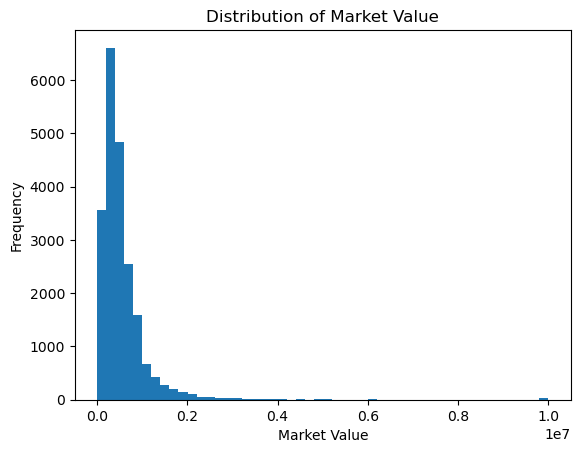

In [40]:
#Histogram of MARKETVAL
plt.figure()
plt.hist(market_data, bins=50)
plt.xlabel("Market Value")
plt.ylabel("Frequency")
plt.title("Distribution of Market Value")
plt.show()

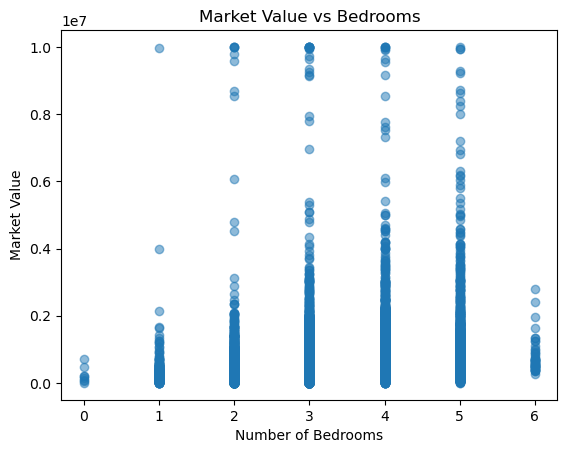

In [41]:
#Scatterplot of BEDROOMS vs MARKETVAL
plt.figure()
plt.scatter(ahs_data["BEDROOMS"], market_data, alpha=0.5)
plt.xlabel("Number of Bedrooms")
plt.ylabel("Market Value")
plt.title("Market Value vs Bedrooms")
plt.show()

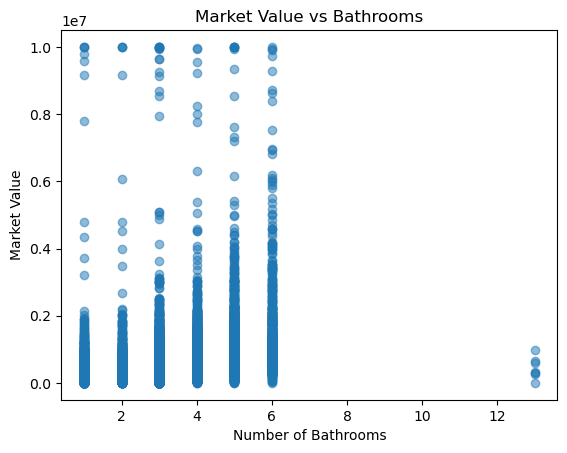

In [42]:
#Scatterplot of BATHROOMS vs MARKETVAL
plt.figure()
plt.scatter(ahs_data["BATHROOMS"], market_data, alpha=0.5)
plt.xlabel("Number of Bathrooms")
plt.ylabel("Market Value")
plt.title("Market Value vs Bathrooms")
plt.show()

In [43]:
# Begin ML Modeling
# fill missing values with median for numeric columns
for col in ahs_data.select_dtypes(include=[np.number]).columns:
    median_value = ahs_data[col].median()
    ahs_data[col].fillna(median_value, inplace=True)
    



/var/folders/1h/zntg658s51n04lht0ylk3zyw0000gn/T/ipykernel_18926/743244735.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  ahs_data[col].fillna(median_value, inplace=True)


In [ ]:
# Serperate Categorical and Numeric Columns
summary_df = ahs_data.copy()
summary_df["MARKETVAL"] = market_data  
numeric_cols = summary_df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = summary_df.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"Numeric columns: {len(numeric_cols)}")
print(f"Categorical columns: {len(categorical_cols)}")


numeric_df = summary_df[numeric_cols]
numeric_corrs = numeric_df.corr()["MARKETVAL"].abs().sort_values(ascending=False)
top_numeric = numeric_corrs.index[1:21].tolist()  # Top 20 numeric
print("\nTop numeric features:")
print(numeric_corrs.head(21))


categorical_corrs = {}
for col in categorical_cols:
    try:
        # Only encode if reasonable number of categories
        n_unique = summary_df[col].nunique()
        if n_unique < 50 and n_unique > 1:  # Skip if too many or constant
            le = LabelEncoder()
            encoded = le.fit_transform(summary_df[col].astype(str))
            
            # Calculate correlation with MARKETVAL
            valid_idx = ~summary_df['MARKETVAL'].isna()
            corr = np.corrcoef(encoded[valid_idx], 
                              summary_df.loc[valid_idx, 'MARKETVAL'])[0, 1]
            categorical_corrs[col] = abs(corr)
    except:
        pass

cat_corr_series = pd.Series(categorical_corrs).sort_values(ascending=False)
print(f"\nTop categorical features:")
print(cat_corr_series.head(10))

# Get top 10 features
all_correlations = pd.concat([
    numeric_corrs.drop('MARKETVAL'),
    cat_corr_series
]).sort_values(ascending=False)

top_10_features = all_correlations.head(10).index.tolist()

print(top_10_features)

Numeric columns: 567
Categorical columns: 825

Top numeric features:
MARKETVAL       1.000000
PROTAXAMT       0.565022
INSURAMT        0.426651
TOTHCAMT        0.331560
HINCP           0.306941
FINCP           0.306634
TOTBALAMT       0.298318
BATHROOMS       0.276430
TOTROOMS        0.230390
BEDROOMS        0.201078
WATERAMT        0.195578
MORTAMT         0.194376
UTILAMT         0.188395
PERPOVLVL       0.176405
FINROOMS        0.164814
REMODAMT        0.142976
WEIGHT          0.138548
REPWEIGHT1      0.127515
MAINTAMT        0.127480
REPWEIGHT81     0.125313
REPWEIGHT141    0.123987
Name: MARKETVAL, dtype: float64

Top categorical features:
UNITSIZE     0.240231
HHGRAD       0.207088
GRAD1        0.203977
GRAD2        0.187490
DIVISION     0.179013
FIREPLACE    0.161699
DISHWASH     0.134921
SOLAR        0.126880
COOKFUEL     0.118473
JINTP1       0.111611
dtype: float64
['PROTAXAMT', 'INSURAMT', 'TOTHCAMT', 'HINCP', 'FINCP', 'TOTBALAMT', 'BATHROOMS', 'UNITSIZE', 'TOTROOMS', 'HHGRA

In [45]:
ahs_data = ahs_data[top_10_features]
print(ahs_data.head())

    PROTAXAMT  INSURAMT  TOTHCAMT   HINCP   FINCP  TOTBALAMT  BATHROOMS  \
2         245       267       810  292500  292500         -6          5   
3         122        59       489   56000   56000         -6          3   
7         532       288      1317  186200  186200         -6          4   
9        1014       133      1587  158000   72000         -6          3   
16        248        52       791   61900   61900         -6          5   

   UNITSIZE  TOTROOMS HHGRAD  
2         6         7     47  
3         4         5     39  
7         8         9     45  
9         4         6     40  
16        5         6     45  


In [50]:
X_train, X_test, y_train, y_test = train_test_split(
    ahs_data, market_data, test_size=0.3, random_state=42
)

In [ ]:
# Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y_train)
y_pred_rf = rf_regressor.predict(X_test)

print("Random Forest Regressor Report:")
print(f"R^2 Score: {r2_score(y_test, y_pred_rf):.4f}")
print(f"RMSE: ${np.sqrt(mean_squared_error(y_test, y_pred_rf)):,.2f}")
print(f"MAE: ${mean_absolute_error(y_test, y_pred_rf):,.2f}")

Random Forest Regressor Report:
R² Score: 0.4516
RMSE: $477,770.15
MAE: $212,191.97

Feature Importance:
     feature  importance
0  PROTAXAMT    0.396861
1   INSURAMT    0.175025
2   TOTHCAMT    0.119290
3      HINCP    0.063136
4      FINCP    0.052741
9     HHGRAD    0.052549
5  TOTBALAMT    0.051676
6  BATHROOMS    0.034371
8   TOTROOMS    0.030713
7   UNITSIZE    0.023637


In [52]:
# K-Nearest Neighbors Regressor
scaler = sklearn.preprocessing.StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn_regressor = KNeighborsRegressor(n_neighbors=5)
knn_regressor.fit(X_train_scaled, y_train)
y_pred_knn = knn_regressor.predict(X_test_scaled)

print("K-Nearest Neighbors Regressor Report:")
print(f"R² Score: {r2_score(y_test, y_pred_knn):.4f}")
print(f"RMSE: ${np.sqrt(mean_squared_error(y_test, y_pred_knn)):,.2f}")
print(f"MAE: ${mean_absolute_error(y_test, y_pred_knn):,.2f}")

K-Nearest Neighbors Regressor Report:
R² Score: 0.3705
RMSE: $511,876.63
MAE: $231,524.10


In [ ]:
# Lasso Regression
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)

print("Lasso Regression Report:")
print(f"R² Score: {r2_score(y_test, y_pred_lasso):.4f}")
print(f"RMSE: ${np.sqrt(mean_squared_error(y_test, y_pred_lasso)):,.2f}")
print(f"MAE: ${mean_absolute_error(y_test, y_pred_lasso):,.2f}")


Lasso Regression Report:
R² Score: 0.4123
RMSE: $494,600.09
MAE: $222,286.64

Lasso Coefficients:
     feature   coefficient
6  BATHROOMS  24307.288784
8   TOTROOMS   3434.605045
7   UNITSIZE   3347.774542
1   INSURAMT   1189.844739
9     HHGRAD    977.753482
0  PROTAXAMT    469.139478
2   TOTHCAMT     14.914014
3      HINCP      0.326516
5  TOTBALAMT      0.316498
4      FINCP     -0.046671

Features with non-zero coefficients: 10/10


/opt/anaconda3/envs/ds/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.733e+13, tolerance: 6.881e+11
  model = cd_fast.enet_coordinate_descent(
